In [254]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize

In [144]:
# Load dataset
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Spin up
The net flux converges towards zero if the [actual surface pressure](https://jduffield65.github.io/Isca/namelists/main/spectral_dynamics/#ps) is used to [compute](https://jduffield65.github.io/Isca/code/utils/radiation/#isca_tools.utils.radiation.frierson_net_toa_sw_dwn) the net shortwave radiation at the top of the atmosphere.

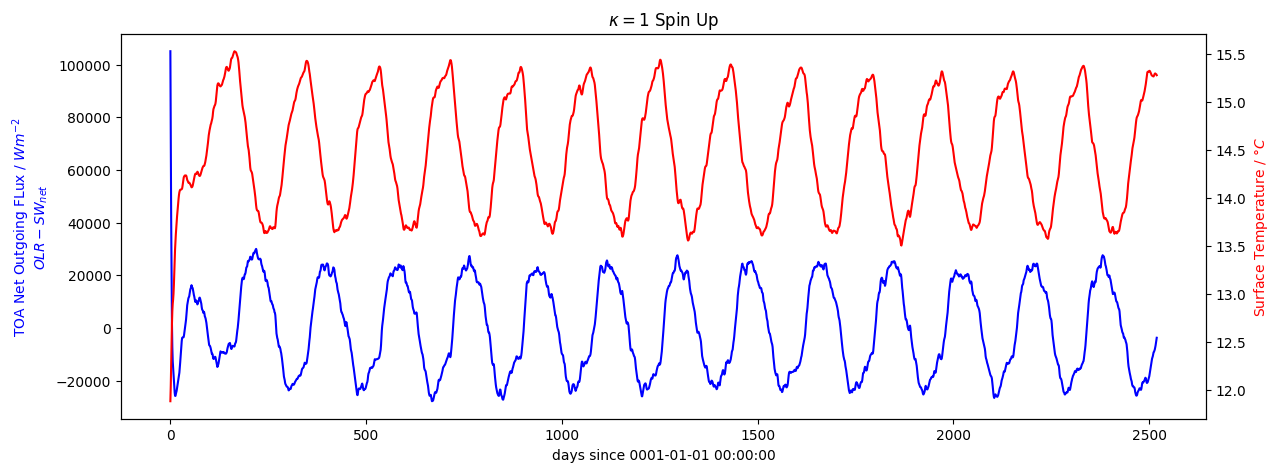

In [251]:
# Plot spin up time
spin_up_ind = np.where(np.asarray(tau_lw)==1)[0][0]     # Use dataset with earthlike optical depth for spin up plot
fig, ax = plt.subplots(1,1, figsize=(14, 5))
isca_tools.plot.plot_spin_up(ds[spin_up_ind].olr, frierson_net_toa_sw_dwn(ds[spin_up_ind].swdn_toa, ds[spin_up_ind].ps,
                                                                          albedo[spin_up_ind], tau_sw[spin_up_ind]),
                             ds[spin_up_ind].t_surf, ax)
plt.title('$\kappa = 1$ Spin Up');

## Surface Temperature Quantile
Plot quantile of surface temperature vs global average surface temperature for a given latitude band.

Here, we compute the quantile at each latitude coordinate across all longitudes and time and then average over these.

In [146]:
# Compute Global Average Surface Temperature
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
temp_av = np.zeros(n_exp)
for i in range(n_exp):
    temp_av[i] = area_weighting(ds[i].sel(time=slice(use_time_start, np.inf)).t_surf).mean(dim=['lon', 'lat', 'time']).to_numpy()


In [147]:
# Compute quantile surface temperature across longitude and time dimension for each latitude
quantiles = [90, 99, 99.9, 99.99]
n_quantiles = len(quantiles)
latitudes = ds[0].lat.to_numpy()
n_latitude = len(latitudes)
weights = np.cos(np.deg2rad(latitudes))
temp_quant = np.zeros((n_exp, n_quantiles, n_latitude))
for i in range(n_exp):
    # Collapse longitude and time dimensions because they are all equivalent in an aquaplanet (expect for the seasonality).
    data_use = ds[i].sel(time=slice(use_time_start, np.inf)).t_surf.stack(lon_time=("lon","time"),
                                                                          create_index=False).chunk(dict(lon_time=-1))
    for j in range(n_quantiles):
        temp_quant[i, j, :] = data_use.quantile(quantiles[j]/100, dim='lon_time').to_numpy()


In [150]:
# Only consider a given latitude range
lat_min = 0
lat_max = 10
lat_use = np.where(np.logical_and(np.abs(latitudes)<lat_max, np.abs(latitudes)>=lat_min))[0]
temp_quant_use = np.average(temp_quant[:, :, lat_use], axis=2, weights = weights[lat_use])

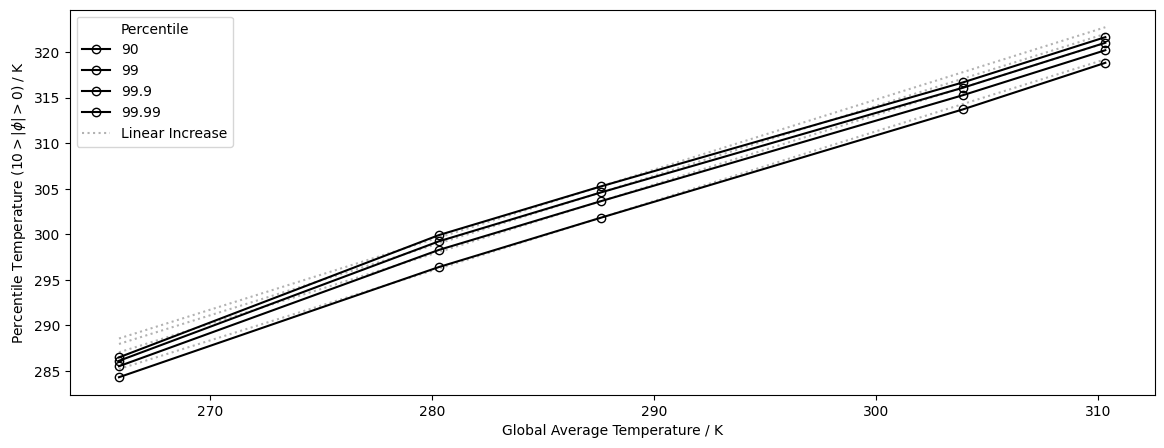

In [268]:
tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
fig, ax = plt.subplots(1,1, figsize=(14, 5))
for j in range(n_quantiles):
    ax.plot(temp_av, temp_quant_use[:, j], marker='o', label=quantiles[j], color='k', fillstyle='none')
    fit_func = lambda x, m: temp_quant_use[tau_ref_ind, j] + m*(x-temp_av[tau_ref_ind])         # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant_use[:, j])[0]
    if j==n_quantiles-1:
        label = 'Linear Increase'
    else:
        label = None
    ax.plot(temp_av, fit_func(temp_av, param), linestyle=':', color='k', alpha=0.3, label=label)
ax.legend(title='Percentile')
ax.set_xlabel('Global Average Temperature / K')
ax.set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| > {lat_min}$) / K');

The linear increase above and below is just a straight line fit that goes through the reference point, for which the optical depth parameter is 1.

The plot below shows the quantiles computed across all latitudes, longitudes and time in the given latitude range. There doesn't really seem to be much difference between the two methods of computing the quantiles.

In [177]:
# Compute quantile across all selected latitudes rather than for each latitude.
temp_quant_use2 = np.zeros((n_exp, n_quantiles))
for i in range(n_exp):
    # Collapse longitude and time dimensions because they are all equivalent in an aquaplanet (expect for the seasonality).
    data_use = ds[i].where((np.abs(ds[i].lat) <= lat_max) & (np.abs(ds[i].lat) >= lat_min), drop=True)
    data_use = data_use.sel(time=slice(use_time_start, np.inf)).t_surf.stack(lon_lat_time=("lon","time", "lat"),
                                                                             create_index=False).chunk(dict(lon_lat_time=-1))
    for j in range(n_quantiles):
        temp_quant_use2[i, j] = data_use.quantile(quantiles[j]/100, dim='lon_lat_time').to_numpy()

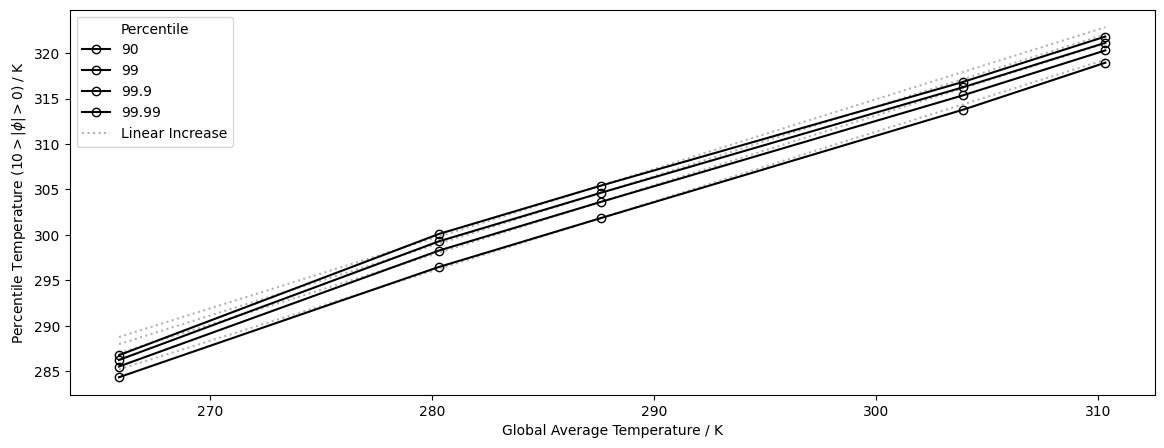

In [269]:
fig, ax = plt.subplots(1,1, figsize=(14, 5))
for j in range(n_quantiles):
    ax.plot(temp_av, temp_quant_use2[:, j], marker='o', label=quantiles[j], color='k', fillstyle='none')
    fit_func = lambda x, m: temp_quant_use2[tau_ref_ind, j] + m*(x-temp_av[tau_ref_ind])     # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant_use2[:, j])[0]
    if j==n_quantiles-1:
        label = 'Linear Increase'
    else:
        label = None
    ax.plot(temp_av, fit_func(temp_av, param), linestyle=':', color='k', alpha=0.3, label=label)
ax.legend(title='Percentile')
ax.set_xlabel('Global Average Temperature / K')
ax.set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| > {lat_min}$) / K');

## Variation with latitude
The plot below is inspired by Figure 2 in *O'Gorman Schneider 2009*, showing the change in the 99.9 percentile and mean temperature with respect to a reference experiment, as a function of latitude.


In [228]:
# Get change in a given percentile of temperature between a warmer simulation and a reference
quant_plot = 99.9
tau_lw_ref = 1
tau_lw_warm = 3.5
temp_quant_ref = temp_quant[np.asarray(tau_lw)==tau_lw_ref, np.asarray(quantiles)==quant_plot, :].flatten()
temp_quant_warm = temp_quant[np.asarray(tau_lw)==tau_lw_warm, np.asarray(quantiles)==quant_plot, :].flatten()
temp_quant_diff = (temp_quant_warm-temp_quant_ref)
global_temp_diff = float(temp_av[np.asarray(tau_lw)==tau_lw_warm] - temp_av[np.asarray(tau_lw)==tau_lw_ref])

In [229]:
# Get change in mean temperature
mean_temp_ref = ds[np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]].sel(time=slice(use_time_start, np.inf)
                                                                       ).t_surf.mean(dim=["lon","time"])
mean_temp_warm = ds[np.where(np.asarray(tau_lw)==tau_lw_warm)[0][0]].sel(time=slice(use_time_start, np.inf)
                                                                         ).t_surf.mean(dim=["lon","time"])
mean_temp_diff = (mean_temp_warm-mean_temp_ref)

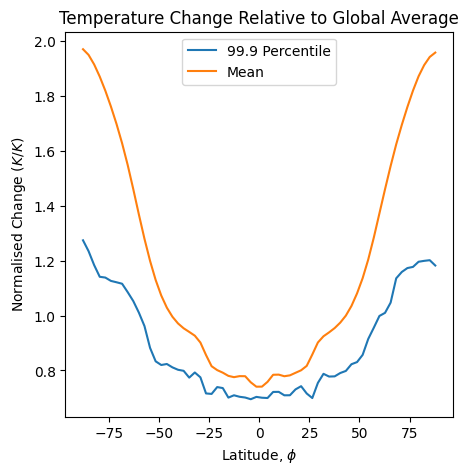

In [244]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.plot(latitudes, temp_quant_diff / global_temp_diff, label=f"{quant_plot} Percentile")
ax.plot(latitudes, mean_temp_diff / global_temp_diff, label="Mean")
ax.set_ylabel('Normalised Change ($K/ K$)')
ax.set_xlabel('Latitude, $\phi$')
ax.legend()
ax.set_title('Temperature Change Relative to Global Average');